In [1]:
!pip install scikit-learn
!pip install pandas
# !pip install da4ml
# For da4ml, also required: !conda install conda-forge::verilator -y

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install keras

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pquant-ml[torch]

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
  Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (6.6 kB)
Using cached tensorflow-2.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.6 MB)
Using cached numpy-2.4.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.7 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [11]:
!pip uninstall -y \
  tensorflow tensorflow-cpu tensorflow-intel \
  tf-nightly keras keras-nightly \
  optree dmtree \
  numpy


Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: keras 3.13.0
Uninstalling keras-3.13.0:
  Successfully uninstalled keras-3.13.0
Found existing installation: optree 0.18.0
Uninstalling optree-0.18.0:
  Successfully uninstalled optree-0.18.0
Found existing installation: numpy 2.4.1
Uninstalling numpy-2.4.1:
  Successfully uninstalled numpy-2.4.1


In [15]:
!pip install \
  numpy>=2.0 \
  keras==3.1.1 \
  torch \
  optree


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
hgq2 0.1.6 requires keras>=3.11, but you have keras 3.1.1 which is incompatible.


In [9]:
!pip install -U numpy>=2.0


In [3]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import random
import numpy as np
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pquant
import torch

import keras
keras.backend.set_image_data_format("channels_first")
from pquant.layers import PQDense
from pquant.activations import PQActivation
from pquant import get_ebops
# from da4ml.trace.ops import quantize, relu
# from da4ml.trace import comb_trace, FixedVariableArrayInput, FixedVariableArray
# from da4ml.codegen import VerilogModel
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)

/eos/user/a/apetrovy/.local/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:


import pickle as pkl
from pathlib import Path

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def get_data(data_path: Path, seed=42):
    try:
        import zstd
    except ImportError:
        zstd = None
    if not os.path.exists(data_path):
        print('Downloading data...')
        data = fetch_openml('hls4ml_lhc_jets_hlf')
        buf = pkl.dumps(data)
        with open(data_path, 'wb') as f:
            if zstd is not None:
                buf = zstd.compress(buf)
            f.write(buf)
    else:
        os.makedirs(data_path.parent, exist_ok=True)
        with open(data_path, 'rb') as f:
            buf = f.read()
            if zstd is not None:
                buf = zstd.decompress(buf)
            data = pkl.loads(buf)

    X, y = data['data'], data['target']
    codecs = {'g': 0, 'q': 1, 't': 4, 'w': 2, 'z': 3}
    y = np.array([codecs[i] for i in y])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_val, X_test, y_train_val, y_test = X_train_val.astype(np.float32), X_test.astype(np.float32), y_train_val, y_test

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)

    X_train_val = X_train_val.astype(np.float32)
    y_train_val = y_train_val.astype(np.float32)

    return X_train_val, X_test, y_train_val, y_test


X_train, X_test, y_train, y_test = get_data(Path('/tmp/inp_data.zst'))
np.random.seed(42)
random.seed(42)

In [5]:
X_train

array([[-0.5112194 ,  0.4709012 ,  0.3854093 , ..., -0.8356734 ,
         0.1872339 ,  0.4656152 ],
       [ 0.74837166, -0.49861702,  0.12397022, ..., -0.4347707 ,
         0.2630706 , -0.8720775 ],
       [ 0.8549553 , -0.9071467 , -1.2185662 , ...,  1.3785621 ,
        -1.2894171 , -0.7336955 ],
       ...,
       [ 1.7038691 , -2.5647378 , -1.2492837 , ..., -0.40030617,
        -1.3103083 , -1.0565869 ],
       [-0.00470833,  0.27720675,  1.2619908 , ...,  1.5371776 ,
         1.7332124 ,  0.00434187],
       [-1.4528095 ,  0.83477974,  0.59786695, ..., -0.57906324,
         0.89104605,  2.080072  ]], dtype=float32)

In [6]:
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_t = torch.from_numpy(X_train).float()
X_test_t  = torch.from_numpy(X_test).float()

y_train_idx = torch.from_numpy(y_train).long()
y_test_idx  = torch.from_numpy(y_test).long()

y_train_oh = F.one_hot(y_train_idx, num_classes=5).float()
y_test_oh  = F.one_hot(y_test_idx,  num_classes=5).float()

train_ds = TensorDataset(X_train_t, y_train_oh)
test_ds  = TensorDataset(X_test_t,  y_test_oh)


train_loader = DataLoader(train_ds, batch_size=33200, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_ds,  batch_size=33200, shuffle=False, num_workers=4)



In [ ]:
from pquant import cs_config, dst_config

def build_model(config):
    class Model(torch.nn.Module):
        def __init__(self, config):
            super().__init__()
            self.dense1 = PQDense(config, 16, 64, 
                                  in_quant_bits = (1, 3, 3))
            self.relu = PQActivation(config, "relu")
            self.dense2 = PQDense(config, 64, 32)
            self.dense3 = PQDense(config, 32, 32)
            self.dense4 = PQDense(config, 32, 5, 
                                  quantize_output=True, 
                                  out_quant_bits=(1, 3, 3))

        def forward(self, x):
            x = self.relu(self.dense1(x))
            x = self.relu(self.dense2(x))
            x = self.relu(self.dense3(x))
            x = self.dense4(x)
            return x
    return Model(config)

config = dst_config()
config.training_parameters.epochs = 1000
config.quantization_parameters.default_data_integer_bits = 3.
config.quantization_parameters.default_data_fractional_bits = 2.
config.quantization_parameters.default_weight_fractional_bits = 3.
config.quantization_parameters.use_relu_multiplier = False
config.quantization_parameters.overflow_mode_data = "WRAP"
config.quantization_parameters.overflow_mode_parameters = "SAT"
config.quantization_parameters
model = build_model(config)

model.to("cuda")
model(torch.rand(1, 16).to("cuda")) # Call once to build Keras layers

/eos/user/a/apetrovy/.local/lib/python3.11/site-packages/pquant/core/torch/quantizer.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.k = torch.nn.Parameter(torch.tensor(k), requires_grad=False)
/eos/user/a/apetrovy/.local/lib/python3.11/site-packages/pquant/core/torch/quantizer.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.i = torch.nn.Parameter(torch.tensor(i), requires_grad=False)
/eos/user/a/apetrovy/.local/lib/python3.11/site-packages/pquant/core/torch/quantizer.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[0.1250, 0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<DivBackward0>)

In [8]:
model

Model(
  (dense1): PQDense(
    in_features=16 out_features=64 bias=True quantize_input=True quantize_output=False 
    (pruning_layer): <DST name=dst, built=True>
    (input_quantizer): Quantizer()
    (weight_quantizer): Quantizer()
    (bias_quantizer): Quantizer()
    (output_quantizer): Quantizer()
  )
  (relu): PQActivation(
    quantize_input = True, quantize_output = False
    (output_quantizer): Quantizer()
    (input_quantizer): Quantizer()
  )
  (dense2): PQDense(
    in_features=64 out_features=32 bias=True quantize_input=True quantize_output=False 
    (pruning_layer): <DST name=dst_1, built=True>
    (input_quantizer): Quantizer()
    (weight_quantizer): Quantizer()
    (bias_quantizer): Quantizer()
    (output_quantizer): Quantizer()
  )
  (dense3): PQDense(
    in_features=32 out_features=32 bias=True quantize_input=True quantize_output=False 
    (pruning_layer): <DST name=dst_2, built=True>
    (input_quantizer): Quantizer()
    (weight_quantizer): Quantizer()
    (bi

In [9]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=1e-2, params=model.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[600, 800], gamma=0.1)

In [10]:
from pquant import get_layer_keep_ratio, get_model_losses
train_accuracies = []
train_task_losses = []
train_model_losses = []
train_total_losses = []
epoch_task_loss = 0
epoch_model_loss = 0
epoch_total_loss = 0
epoch_acc = 0
n_batches = 0

def training_loop(model, trainloader, device, loss_function, optimizer, epoch, scheduler=None, *args, **kwargs):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        epoch_task_loss = 0.0
        epoch_model_loss = 0.0
        epoch_total_loss = 0.0
        epoch_acc = 0.0
        n_batches = 0

        outputs = model(inputs)

        task_loss = loss_function(outputs, labels)
        model_loss = get_model_losses(
            model, torch.tensor(0.).to(device)
        )

        total_loss = task_loss + model_loss
        total_loss.backward()
        optimizer.step()

        acc = torch.mean(
            (torch.argmax(outputs, dim=1)
             == torch.argmax(labels, dim=1)).float()
        )

        epoch_task_loss += task_loss.item()
        epoch_model_loss += model_loss.item()
        epoch_total_loss += total_loss.item()
        epoch_acc += acc.item()
        n_batches += 1

    if scheduler is not None:
        scheduler.step()

    train_task_losses.append(epoch_task_loss / n_batches)
    train_model_losses.append(epoch_model_loss / n_batches)
    train_total_losses.append(epoch_total_loss / n_batches)
    train_accuracies.append(epoch_acc / n_batches)

val_accuracies = []
remaining_weights = []
ebops = []
val_losses = []
def validate_loop(model, testloader, device, loss_function, epoch, *args, **kwargs):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            val_losses.append(loss)
            accuracy = torch.mean((torch.argmax(outputs, dim=1) == torch.argmax(labels, dim=1)).float())
        val_accuracies.append(accuracy.cpu().numpy())
        ratio = get_layer_keep_ratio(model)
        remaining_weights.append(ratio.cpu().numpy())
        ebops.append(get_ebops(model).cpu().numpy())


In [11]:
from pquant import train_model
model.to("cuda")
trained_model = train_model(model = model, 
                                config = config, 
                                train_func = training_loop, 
                                valid_func = validate_loop, 
                                trainloader = train_loader, 
                                device="cuda",
                                testloader = test_loader, 
                                loss_function = loss_function,
                                optimizer = optimizer,
                                scheduler=scheduler
                                )
print(f"Remaining weights={remaining_weights[-1] * 100:.2f}%", f"   EBOPs={int(ebops[-1])}", f"   Accuracy={val_accuracies[-1]*100:.2f}:%")

/eos/user/a/apetrovy/.local/lib/python3.11/site-packages/keras/src/backend/torch/numpy.py:649: UserWarning: Tensor.T is deprecated on 0-D tensors. This function is the identity in these cases. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  return cast(torch.count_nonzero(x, dim=axis).T, "int32")


Remaining weights=5.26%    EBOPs=5493    Accuracy=18.59:%


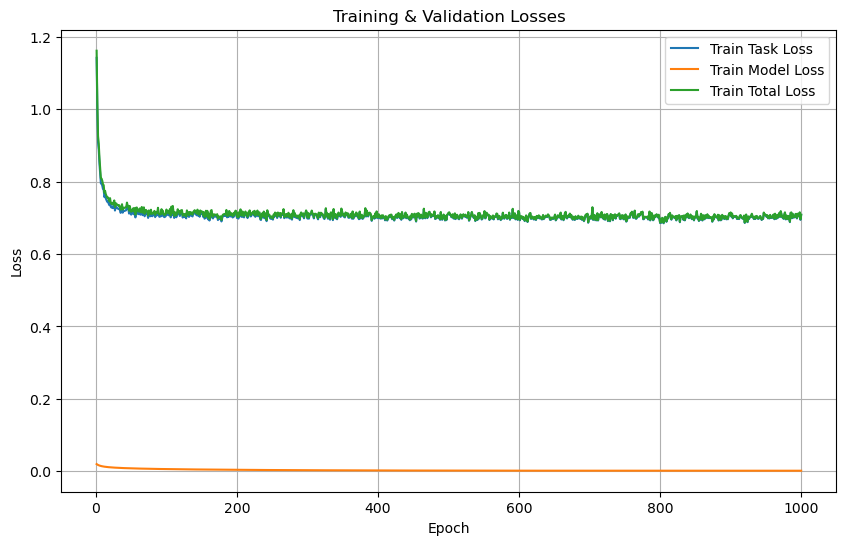

In [15]:
epochs = range(1, len(train_total_losses) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_task_losses, label="Train Task Loss")
plt.plot(epochs, train_model_losses, label="Train Model Loss")
plt.plot(epochs, train_total_losses, label="Train Total Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Losses")
plt.legend()
plt.grid(True)

plt.show()

In [18]:
max(train_model_losses)
#min(train_task_losses)

0.019663196057081223

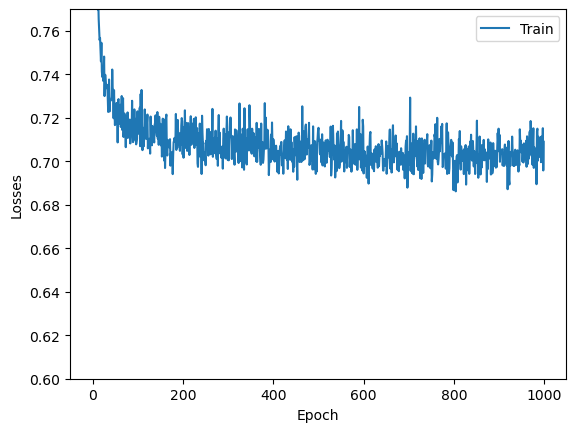

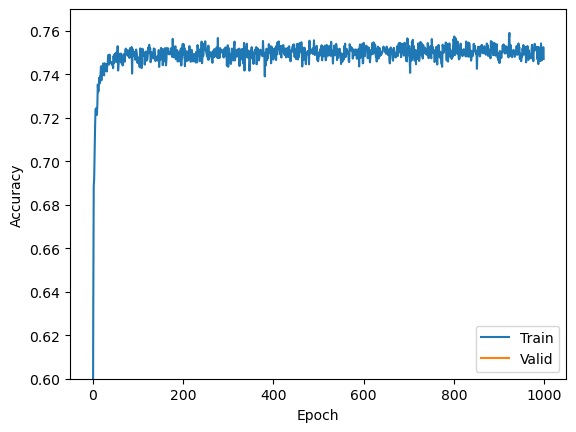

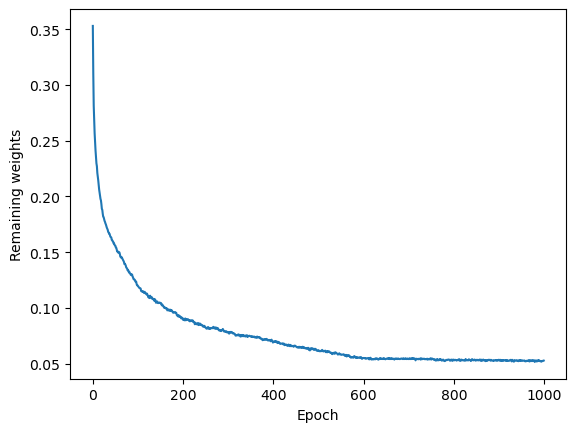

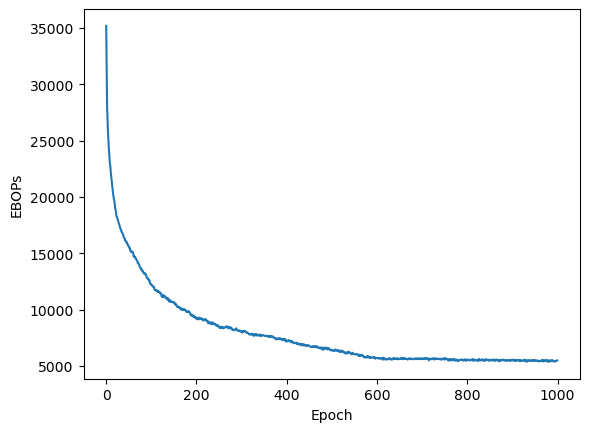

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_total_losses, label="Train")
plt.ylabel("Losses")
plt.xlabel('Epoch')
plt.ylim(0.6, 0.77)
plt.legend()
plt.show()


plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Valid")
plt.ylabel("Accuracy")
plt.xlabel('Epoch')
plt.ylim(0.6, 0.77)
plt.legend()
plt.show()


plt.plot(remaining_weights)
plt.ylabel('Remaining weights')
plt.xlabel('Epoch')
plt.show()

plt.plot(ebops)
plt.ylabel('EBOPs')
plt.xlabel('Epoch')
plt.show()

# da4ml
For this part you need to have verilator installed (conda install conda-forge::verilator -y). We extract the weight and bias matrices from the model as numpy arrays, and build the forward pass of the model using numpy operations.

In [ ]:
w0, b0 = model.dense1.weight.detach().cpu().numpy(), model.dense1.bias.detach().cpu().numpy()
w1, b1 = model.dense2.weight.detach().cpu().numpy(), model.dense2.bias.detach().cpu().numpy()
w2, b2 = model.dense3.weight.detach().cpu().numpy(), model.dense3.bias.detach().cpu().numpy()
w3, b3 = model.dense4.weight.detach().cpu().numpy(), model.dense4.bias.detach().cpu().numpy()

In [ ]:
data_i = int(config.quantization_parameters.default_data_integer_bits)
data_f = int(config.quantization_parameters.default_data_fractional_bits)
data_np_test = np.clip(X_test_t, -(2**data_i), 2**data_i-2**(-data_f))
import yaml
if True:
        inp = FixedVariableArrayInput((16))
        print("pre-quant min/max:", inp.min(), inp.max())
        x = quantize(inp, k=1, i=data_i, f=data_f, overflow_mode="WRAP", round_mode="RND")

        x = w0 @ x
        x = x + b0
        print("pre-quant min/max:", x.min(), x.max())

        x = quantize(x, k=0, i=data_i, f=data_f, overflow_mode="SAT", round_mode="RND")   
        x = w1 @ x
        x = x + b1
        x = quantize(x, k=0, i=data_i, f=data_f, overflow_mode="SAT", round_mode="RND")   
        x = w2 @ x
        x = x + b2
        x = quantize(x, k=0, i=data_i, f=data_f, overflow_mode="SAT", round_mode="RND")   
        x = w3 @ x
        x = x + b3
        out = quantize(x, k=1, i=data_i, f=data_f, overflow_mode="SAT", round_mode="RND")   


        comb_logic = comb_trace(inp, out)
        verilog_model = VerilogModel(comb_logic, "vmodel", "path_to_model_folder", latency_cutoff=5, clock_uncertainty=0., part_name="xcu250-figd2104-2L-e")
        verilog_model.write()
        verilog_model.compile(verbose=True)
        
verilog_model